In [1]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

### Setup the notebook.

In [2]:
import h5py
import math
testNames=["second_order_reversible_time_limit"]
test_names_bash_list=" ".join(testNames)
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [3]:
%%bash
rm -rf tmp && mkdir tmp

### Execute the simulations.

In [4]:
%%bash -s "$test_names_bash_list"
sbmlFilename="second_order_reversible.sbml"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    rm -f ${outputFilename}* && lm_sbml_import ${outputFilename} ${sbmlFilename} > ${outputFilename}.import.log
    if [ ${testName} == "second_order_reversible_time_limit" ]; then
        lm_setp ${outputFilename} writeInterval=1e-2 maxTime=1e1 > /dev/null
    else
        echo "Invalid test name: ${testName}"
        continue
    fi
    lmes -r 1-1000 -f ${outputFilename} > ${outputFilename}.simulate.log
done;
echo "Finished."

Finished.


### Spot check some simulations.

In [5]:
# Plot the time series for a single replicate.
for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
3.4
pass

### Define the tests.

In [6]:
def test_second_order_reversible_time_limit(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    for replicate in replicates:
        if times is None:
            times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        if mSim is None:
            k += 1
            mSim = counts
            vSim = np.zeros(counts.shape, dtype=double)
        else:
            k += 1
            mSim = mSim + (counts-mSim)/k
            vSim = vSim + (counts-mSim)*(counts-mSim)
    vSim /= float((k-1))

    # Plot the mean and variance.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3)})
    ax=plt.subplot(1,2,1)
    plt.plot(times,mSim[:,0], **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(1,2,2)
    plt.plot(times,vSim[:,0], **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('Var{X(t)}'); title("%s"%(testOutputFilename))
    fp.close()

    value = np.mean(mSim[len(mSim)//2:])
    if not isclose(value,500.0,1e-2): raise Exception("incorrect value for mean",value)
    value = np.mean(vSim[len(mSim)//2:])
    if not isclose(value,165.0,5e-2): raise Exception("incorrect value for variance",value)

### Run the tests.

[second_order_reversible_time_limit]                         : passed.


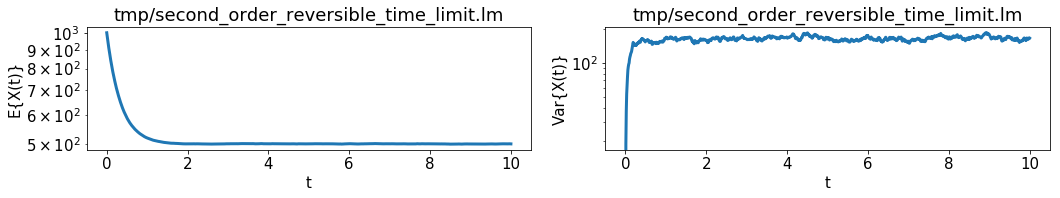

In [7]:
testMethods = {"second_order_reversible_time_limit": test_second_order_reversible_time_limit}
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5*len(testNames))})
i=1
for testName in testNames:
    try:
        testOutputFilename="tmp/%s.lm"%(testName)
        testMethods[testName](testOutputFilename)
    except Exception as e:
        print "%-60s : FAILED with:"%("["+testName+"]"),e
    except:
        print "%-60s : FAILED with: Unknown exception"%("["+testName+"]")
    else:
        print "%-60s : passed."%("["+testName+"]")
    plt.tight_layout()
    plt.show()
pass

In [8]:
%%bash
rm -rf tmp